# Exploring the effect of stacking convolutions

Lets explore what happens if we stack [[Conv] * M] -> ReLU instead of [Conv -> ReLU] * M. We will begin by loading a pretrained VGGNet.

In [6]:
# Lets get some essential; imports out of the way.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from keras import backend as K

In [1]:
from keras.applications import VGG16

vggnet = VGG16()
print vggnet.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

If you peek into the code, you will notice that all `Convolution2D` blocks have ReLU activation. Lets examine what `block1_conv1` computes with/without ReLU.

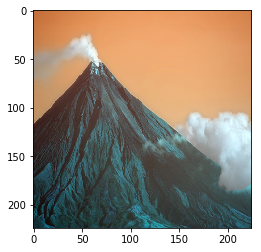

In [5]:
# Load a simple test image.
from utils import load_img

img = load_img("../images/volcano.jpg", target_size=(224, 224))
plt.imshow(img)

`block1_conv1` has shape `(None, 224, 224, 64)` and uses 3 X 3 filter kernel. What this means is that:
- It has 64, 3 X 3 learnable filters, each of which is trying to look for some pattern spatially within 224 X 224 input image. 
- If you think about it, dot product is related to cosine similarity. So a high value after computing dot(img[:3, :3, :], 3 X 3 filter) indicates that it found the desired pattern in the img[:3, :3, :] spatial location. In a way, the conv filter is transforming input image into a new basis where the degree of "pattern" matched is indicated.

In [25]:
# Lets take the first filter and see what it is computing.
conv1 = vggnet.layers[1]

# conv1 has ReLU activation (see code in keras.applications.VGG16). 
# Lets switch this back to linear to see the conv output without any activation.
from keras.activations import linear
conv1.activation = linear

# Input to the conv is float32.
img = img.astype(np.float32)

# Lets compute output of conv1
output = conv1(img)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [23]:
K.conv2d(img.astype(np.float32), filters)

ValueError: Shape must be rank 4 but is rank 3 for 'Conv2D_14' (op: 'Conv2D') with input shapes: [224,224,3], [3,3,3,64].